In [613]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


# Preliminary Data Exploration

In [614]:
df_train = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
df_test = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')
df_all =  pd.concat(objs=[df_train, df_test], axis=0).reset_index(drop=True)

In [615]:
df_train.shape

(8693, 14)

In [616]:
df_test.shape

(4277, 13)

In [617]:
df_all.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,12700.000000,12707.000000,12681.000000,12664.000000,12686.000000,12702.000000
mean,28.771969,222.897852,451.961675,174.906033,308.476904,306.789482
std,14.387261,647.596664,1584.370747,590.558690,1130.279641,1180.097223
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,49.000000,77.000000,29.000000,57.000000,42.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [618]:
df_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [619]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12970 entries, 0 to 12969
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   12970 non-null  object 
 1   HomePlanet    12682 non-null  object 
 2   CryoSleep     12660 non-null  object 
 3   Cabin         12671 non-null  object 
 4   Destination   12696 non-null  object 
 5   Age           12700 non-null  float64
 6   VIP           12674 non-null  object 
 7   RoomService   12707 non-null  float64
 8   FoodCourt     12681 non-null  float64
 9   ShoppingMall  12664 non-null  float64
 10  Spa           12686 non-null  float64
 11  VRDeck        12702 non-null  float64
 12  Name          12676 non-null  object 
 13  Transported   8693 non-null   object 
dtypes: float64(6), object(8)
memory usage: 1.4+ MB


****

In [620]:
# Seperating categorical and numerical columns
# Features not included in categorical or numerical columns consist of an 'other' category that may be explored in more detail later.

other_cols = ['PassengerId', 'Cabin', 'Name']
cat_cols = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']
num_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

In [621]:
# Cardinality is too high to be put in categorical column for now
for item in other_cols:
    print(df_all[item].nunique())

12970
9825
12629


**Visualizing Numerical Data**

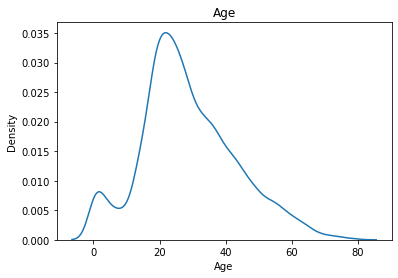

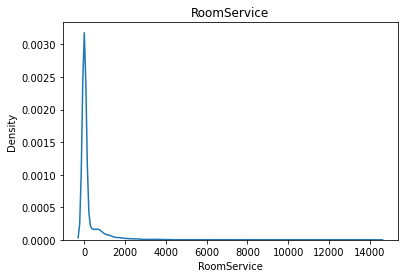

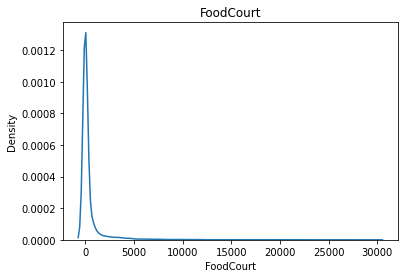

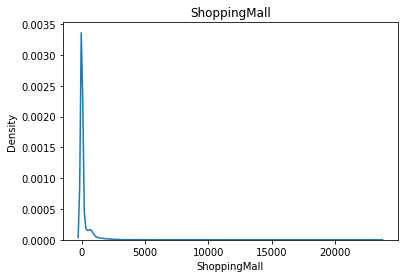

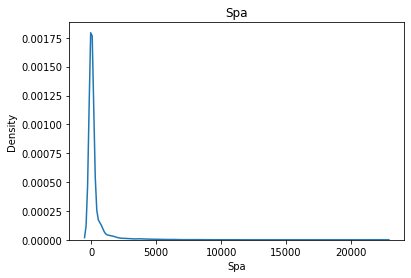

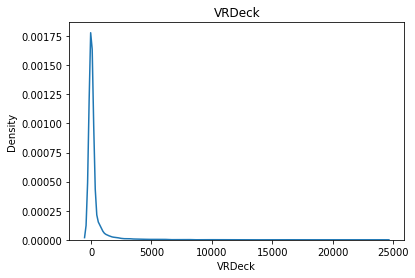

In [622]:
 for item in num_cols:
    sns.kdeplot(data=df_all, x=item)
    plt.title(item)
    plt.show()

The numerical columns besides age are incredibly skewed which may cause higher values to be disproportionately weighted. These variables are prime candidates for log transformation in order to decrease skewness and better normalize the data. This will be done in the feature engineering section. 

In [623]:
#Comparing differences in numerical features for transported and non transported individuals 
pd.pivot_table(df_all, index = 'Transported', values = num_cols)

,Age,FoodCourt,RoomService,ShoppingMall,Spa,VRDeck
Transported,,,,,,
False,29.922858,382.615930,389.266066,167.566217,564.382666,543.629822
True,27.748834,532.691984,63.098021,179.829972,61.675531,69.148131


Looks like those who spent more were less likely to be transported. Additionally, transported individuals were on average younger than those who were not. Lets see if we can gain any further insights into the age feature.

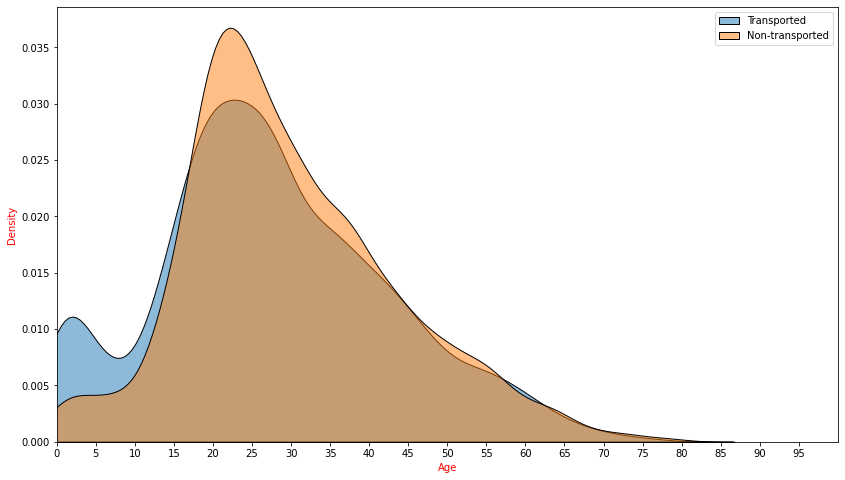

In [624]:
plt.figure(figsize=(14,8))
plt.xlim(0, 100)
sns.kdeplot(data=df_train[df_train.Transported == True], x='Age', shade=True, alpha=0.5, multiple='stack', label='Transported')
sns.kdeplot(data=df_train[df_train.Transported == False], x='Age', alpha=0.5,shade=True, multiple='stack', label='Non-transported')
plt.xlabel("Age",color='red')
plt.ylabel("Density",color='red')
plt.xticks(range(0, 100, 5))
plt.legend()
plt.show()

Interesting, it seems as though transported individuals may be younger on average largely due to the ages of ~ 0-10 being transported at a much higher rate than other age groups. 

**Visualizing Categorical Data**

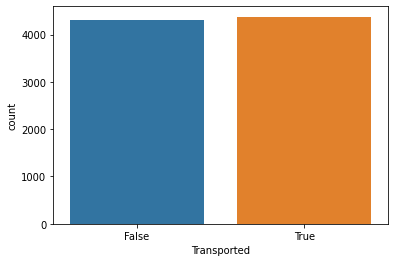

In [625]:
sns.countplot(data=df_train, x='Transported')
plt.show()

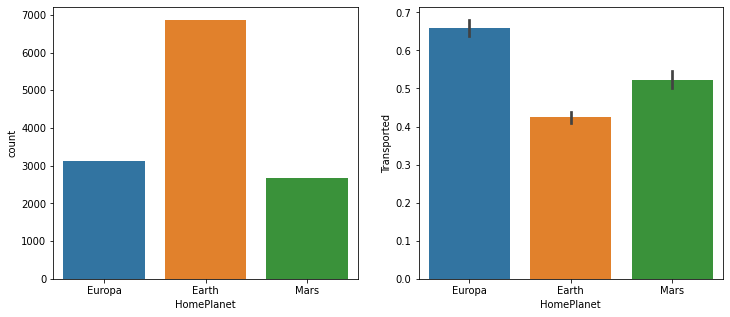

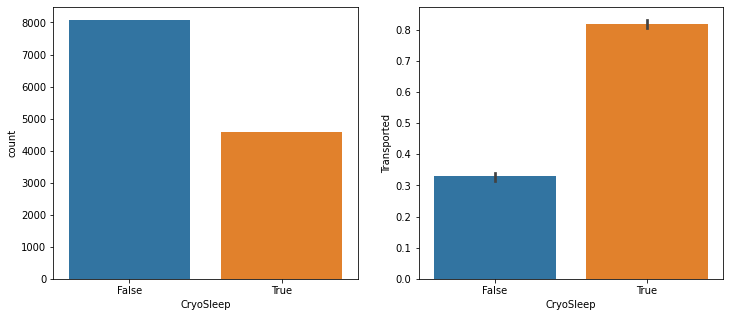

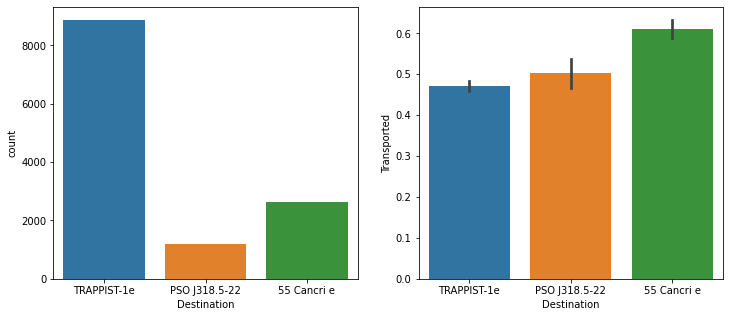

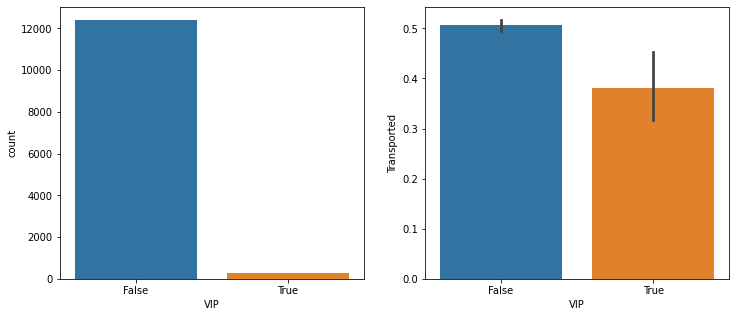

In [626]:
for item in cat_cols:
    fig, ax = plt.subplots(1, 2, figsize=(12,5))
    sns.countplot(data=df_all, x=item, ax=ax[0])
    sns.barplot(data=df_train, x=item, y='Transported', ax=ax[1])    
    fig.show()


It appears that all of these features contain valuable information. About 50% of the population was transported. Most individuals have a home planet of Earth yet those from Europa were transported disproportionately. Those in cryosleep were much more likely to be transported than those awake. The destination feature seems to slightly favor transportation for those traveling to Cancri. Finally, 50% of non-VIPS were transported however transportation rate for VIPS was slightly under 40%. 

# Feature Engineering

**Spending**

Lets log transform all forms of spending

In [627]:
spending_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

In [628]:
for item in spending_cols:
    df_all[item] = df_all[item].map(lambda i: np.log(i) if i > 0 else 0)

Let's also create a total spending column. Nan values have been overidden. However, a total spending column will mitigate loss of information.

In [629]:
df_all['TotalSpending'] = df_all[spending_cols].sum(axis=1)

**Passenger ID**

Passenger IDs tell us if an individual is traveling in a group if the first four digits of their ID are non unique. We can create a groupsize feature which may give us some additional information. 

In [630]:
df_all['GroupId'] = df_all.PassengerId.apply(lambda x: x.split('_')[0])

In [631]:
group_sizes = pd.DataFrame(df_all['GroupId'].value_counts(dropna=False).sort_index())
group_sizes.rename(columns={'GroupId' : 'GroupSize'}, inplace=True)
group_sizes['GroupId'] = group_sizes.index
df_all['GroupSize'] = df_all.merge(group_sizes, on = 'GroupId', how='left')['GroupSize']

In [632]:
df_all.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,TotalSpending,GroupId,GroupSize
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.000000,0.000000,0.000000,0.000000,0.000000,Maham Ofracculy,False,0.000000,0001,1
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,4.691348,2.197225,3.218876,6.308098,3.784190,Juanna Vines,True,20.199736,0002,1
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,3.761200,8.182000,0.000000,8.812099,3.891820,Altark Susent,False,24.647120,0003,2
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.000000,7.156956,5.916202,8.110427,5.262690,Solam Susent,False,26.446276,0003,2
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,5.713733,4.248495,5.017280,6.336826,0.693147,Willy Santantines,True,22.009481,0004,1


In [633]:
df_all[['GroupSize', 'Transported']].groupby('GroupSize').mean()

,Transported
GroupSize,
1,0.452445
2,0.538050
3,0.593137
4,0.640777
5,0.592453
6,0.614943
7,0.541126
8,0.394231


At first glance it looks like those traveling in groups are more likely to be transported than those traveling alone. 

**Cabin**

The cabin feature contains three different pieces of information. From Kaggle: "Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard." Lets split the cabin feature into three seperate columns. 

In [634]:
df_all[['CabinDeck', 'CabinNumber', 'CabinSide']] = df_all['Cabin'].str.split('/', expand=True)

In [635]:
df_all['CabinNumber'] = pd.to_numeric(df_all['CabinNumber'])

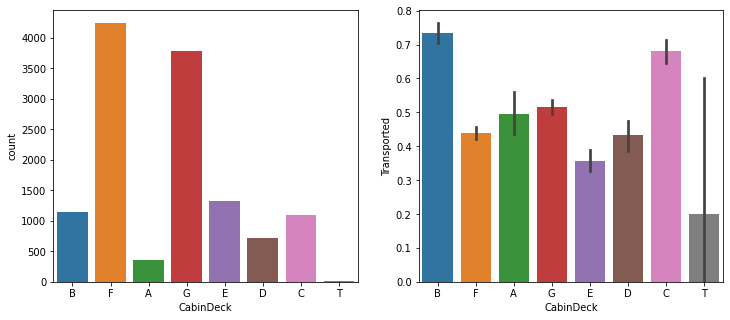

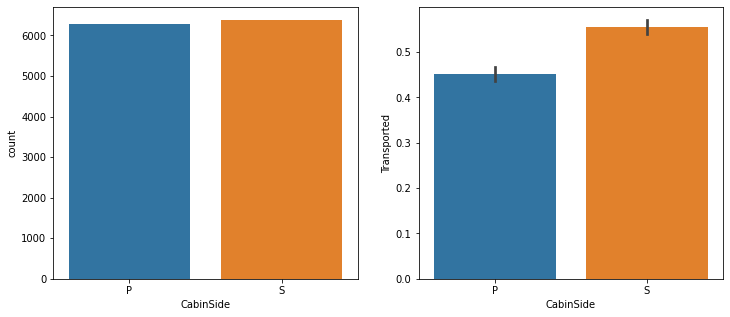

In [636]:
#Visualizing new features

for item in ['CabinDeck', 'CabinSide']:
        fig, ax = plt.subplots(1, 2, figsize=(12,5))
        sns.countplot(data=df_all, x=item, ax=ax[0])
        sns.barplot(data=df_all, x=item, y='Transported', ax=ax[1])    
        fig.show()

It seems as though Cabin Deck and Cabin Side do indeed impact one's chances of being transported. Lets look at Cabin Number. 

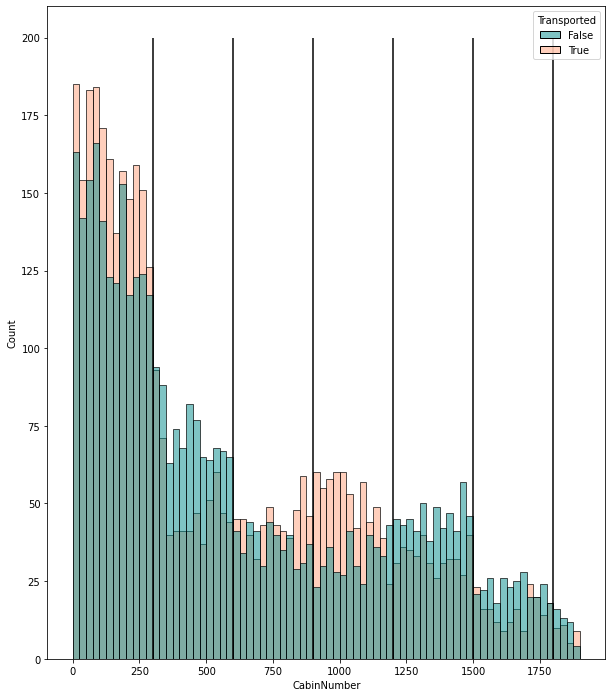

In [637]:
plt.figure(figsize=(10,12))
sns.histplot(df_all, x='CabinNumber', palette=['darkcyan', 'lightsalmon'], hue='Transported', binwidth=25)
plt.vlines(300, ymin=0, ymax=200, color='black')
plt.vlines(600, ymin=0, ymax=200, color='black')
plt.vlines(900, ymin=0, ymax=200, color='black')
plt.vlines(1200, ymin=0, ymax=200, color='black')
plt.vlines(1500, ymin=0, ymax=200, color='black')
plt.vlines(1800, ymin=0, ymax=200, color='black')
plt.show()

It appears as though certain cabin areas are correlated with higher rates of transportation than others. Lets create a cabin area feature in order to further simplify the cabin number feature.  

In [638]:
df_all['CabinArea1']=(df_all['CabinNumber']<300).astype(int)
df_all['CabinArea2']=((df_all['CabinNumber']>=300) 
                      & (df_all['CabinNumber']<600)).astype(int)
df_all['CabinArea3']=((df_all['CabinNumber']>=600) 
                      & (df_all['CabinNumber']<900)).astype(int)
df_all['CabinArea4']=((df_all['CabinNumber']>=900) 
                      & (df_all['CabinNumber']<1200)).astype(int)
df_all['CabinArea5']=((df_all['CabinNumber']>=1200) 
                      & (df_all['CabinNumber']<1500)).astype(int)
df_all['CabinArea6']=(df_all['CabinNumber']<=1500).astype(int)


Lets delete the cabin feature as it is redundant.

In [639]:
df_all.drop(columns='Cabin', inplace=True)

**Name**

After looking into the name feature it seems as though it won't be of much use to our model. However, keeping last names may be useful for imputation purposes. 

In [640]:
df_all.Name.head(5)

0      Maham Ofracculy
1         Juanna Vines
2        Altark Susent
3         Solam Susent
4    Willy Santantines
Name: Name, dtype: object

In [641]:
df_all['Name'] = df_all['Name'].str.split().str[-1]

In [642]:
df_all.Name.head(5)

0      Ofracculy
1          Vines
2         Susent
3         Susent
4    Santantines
Name: Name, dtype: object

# Imputation

In [643]:
df_all.isna().sum()

PassengerId         0
HomePlanet        288
CryoSleep         310
Destination       274
Age               270
VIP               296
RoomService         0
FoodCourt           0
ShoppingMall        0
Spa                 0
VRDeck              0
Name              294
Transported      4277
TotalSpending       0
GroupId             0
GroupSize           0
CabinDeck         299
CabinNumber       299
CabinSide         299
CabinArea1          0
CabinArea2          0
CabinArea3          0
CabinArea4          0
CabinArea5          0
CabinArea6          0
dtype: int64

**Home Planet**

In order to impute missing home planet values lets firest look at the family and group features. 

In [644]:
df_ghp = df_all.groupby(['GroupId','HomePlanet']).size().unstack().fillna(0)
df_ghp.head()

HomePlanet,Earth,Europa,Mars
GroupId,,,
0001,0.0,1.0,0.0
0002,1.0,0.0,0.0
0003,0.0,2.0,0.0
0004,1.0,0.0,0.0
0005,1.0,0.0,0.0


In [645]:
ghp_count = df_ghp.apply(pd.Series.value_counts, axis=1).fillna(0)
ghp_count.head()

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0
GroupId,,,,,,,,,
0001,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0002,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0003,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
0004,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0005,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [646]:
ghp_count[0].nunique()

1

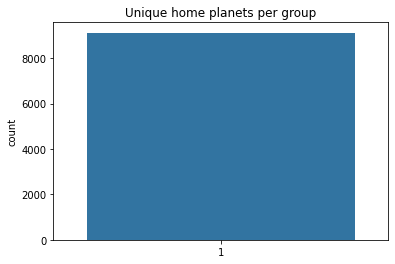

In [647]:
sns.countplot(x=(df_ghp>0).sum(axis=1))
plt.title('Unique home planets per group')
plt.show()

This shows that all members of the same group belong to the same home planet 100% of the time accross all of the given data. This will help us impute some of the missing information since if an individual belongs to a group we can impute their home planet based on the home planet of the group. 

In [648]:
df_all.HomePlanet.isna().sum()

288

In [649]:
ghp_impute = df_all[df_all['HomePlanet'].isna()][(df_all[df_all['HomePlanet'].isna()]['GroupId']).isin(df_ghp.index)].index

In [650]:
df_all.loc[ghp_impute,'HomePlanet']=df_all.iloc[ghp_impute,:]['GroupId'].map(lambda x: df_ghp.idxmax(axis=1)[x])

In [651]:
df_all.HomePlanet.isna().sum()

157

Lets see if we can do the same thing based on families (individuals with the same surname). 

In [652]:
df_nhp = df_all.groupby(['Name','HomePlanet']).size().unstack().fillna(0)
df_nhp.head()

HomePlanet,Earth,Europa,Mars
Name,,,
Acobson,5.0,0.0,0.0
Acobsond,8.0,0.0,0.0
Adavisons,10.0,0.0,0.0
Adkinson,4.0,0.0,0.0
Admingried,0.0,4.0,0.0


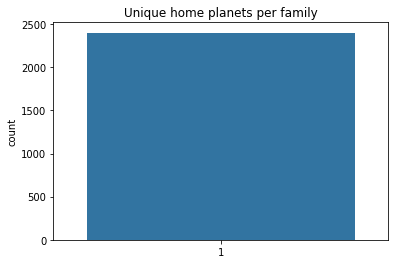

In [653]:
sns.countplot(x=(df_nhp>0).sum(axis=1))
plt.title('Unique home planets per family')
plt.show()

Looks like we see the same thing. Families all belong to the same home planet 100% of the time with our given data. Lets impute again.  

In [654]:
nhp_impute = df_all[df_all['HomePlanet'].isna()][(df_all[df_all['HomePlanet'].isna()]['Name']).isin(df_nhp.index)].index

In [655]:
df_all.loc[nhp_impute,'HomePlanet']=df_all.iloc[nhp_impute,:]['Name'].map(lambda x: df_nhp.idxmax(axis=1)[x])

In [656]:
df_all.HomePlanet.isna().sum()

13

There are only 13 remaining null values for homeplanets lets take a look at them. 

In [657]:
df_all[df_all.HomePlanet.isna()]

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,...,GroupSize,CabinDeck,CabinNumber,CabinSide,CabinArea1,CabinArea2,CabinArea3,CabinArea4,CabinArea5,CabinArea6
234,0251_01,NaN,True,55 Cancri e,54.0,False,0.000000,0.000000,0.000000,0.000000,...,1,C,11.0,S,1,0,0,0,0,1
807,0853_01,NaN,True,55 Cancri e,38.0,False,0.000000,0.000000,0.000000,0.000000,...,1,A,9.0,S,1,0,0,0,0,1
1855,1978_01,NaN,True,TRAPPIST-1e,19.0,False,0.000000,0.000000,0.000000,0.000000,...,1,G,311.0,S,0,1,0,0,0,1
2274,2443_01,NaN,False,TRAPPIST-1e,31.0,False,7.284821,6.042633,4.330733,0.000000,...,1,D,72.0,P,1,0,0,0,0,1
2631,2817_01,NaN,False,TRAPPIST-1e,25.0,False,5.468060,0.000000,6.813445,0.000000,...,1,F,584.0,P,0,1,0,0,0,1
3091,3331_01,NaN,False,TRAPPIST-1e,40.0,False,6.501290,1.386294,4.418841,0.000000,...,1,F,631.0,S,0,0,1,0,0,1
4548,4840_01,NaN,True,TRAPPIST-1e,36.0,False,0.000000,0.000000,0.000000,0.000000,...,1,F,915.0,S,0,0,0,1,0,1
5762,6108_01,NaN,False,TRAPPIST-1e,13.0,False,5.327876,3.332205,0.000000,0.000000,...,1,F,1166.0,S,0,0,0,1,0,1
8969,0616_01,NaN,False,TRAPPIST-1e,31.0,False,0.000000,6.059123,0.000000,7.050989,...,1,E,40.0,S,1,0,0,0,0,1
10583,4052_01,NaN,False,TRAPPIST-1e,26.0,False,1.791759,8.683216,0.000000,5.480639,...,1,D,136.0,P,1,0,0,0,0,1


In order to impute the last 13 homeplanets lets take a look at destination and cabin to see if there are any trends we can draw from. 

In [658]:
df_dhp = df_all.groupby(['Destination','HomePlanet']).size().unstack()
df_dhp

HomePlanet,Earth,Europa,Mars
Destination,,,
55 Cancri e,1000,1339,300
PSO J318.5-22,1085,29,70
TRAPPIST-1e,4777,1769,2314


In [659]:
df_cdhp = df_all.groupby(['CabinDeck','HomePlanet']).size().unstack().fillna(0)
df_cdhp

HomePlanet,Earth,Europa,Mars
CabinDeck,,,
A,0.0,353.0,0.0
B,0.0,1141.0,0.0
C,0.0,1101.0,0.0
D,0.0,306.0,411.0
E,595.0,203.0,523.0
F,2475.0,0.0,1759.0
G,3780.0,0.0,0.0
T,0.0,11.0,0.0


It looks like some cabin decks (A, B, C, and T) belong to individuals all from the same home planet (Europa) and G belongs to Earth. Lets impute entries belonging to these cabin decks first 

In [660]:
df_all.loc[(df_all['HomePlanet'].isna()) & (df_all['CabinDeck'].isin(['A', 'B', 'C', 'T'])), 'HomePlanet'] = 'Europa'
df_all.loc[(df_all['HomePlanet'].isna()) & (df_all['CabinDeck'] == 'G'), 'HomePlanet'] = 'Earth'

In [661]:
# Individual method
#df_all.iloc[234, 1] = 'Europa'

In [662]:
df_all[df_all.HomePlanet.isna()]

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,...,GroupSize,CabinDeck,CabinNumber,CabinSide,CabinArea1,CabinArea2,CabinArea3,CabinArea4,CabinArea5,CabinArea6
2274,2443_01,NaN,False,TRAPPIST-1e,31.0,False,7.284821,6.042633,4.330733,0.000000,...,1,D,72.0,P,1,0,0,0,0,1
2631,2817_01,NaN,False,TRAPPIST-1e,25.0,False,5.468060,0.000000,6.813445,0.000000,...,1,F,584.0,P,0,1,0,0,0,1
3091,3331_01,NaN,False,TRAPPIST-1e,40.0,False,6.501290,1.386294,4.418841,0.000000,...,1,F,631.0,S,0,0,1,0,0,1
4548,4840_01,NaN,True,TRAPPIST-1e,36.0,False,0.000000,0.000000,0.000000,0.000000,...,1,F,915.0,S,0,0,0,1,0,1
5762,6108_01,NaN,False,TRAPPIST-1e,13.0,False,5.327876,3.332205,0.000000,0.000000,...,1,F,1166.0,S,0,0,0,1,0,1
8969,0616_01,NaN,False,TRAPPIST-1e,31.0,False,0.000000,6.059123,0.000000,7.050989,...,1,E,40.0,S,1,0,0,0,0,1
10583,4052_01,NaN,False,TRAPPIST-1e,26.0,False,1.791759,8.683216,0.000000,5.480639,...,1,D,136.0,P,1,0,0,0,0,1
11913,7065_01,NaN,True,TRAPPIST-1e,28.0,False,0.000000,0.000000,0.000000,0.000000,...,1,E,471.0,S,0,1,0,0,0,1
12551,8435_01,NaN,NaN,TRAPPIST-1e,19.0,False,5.087596,2.397895,0.000000,0.000000,...,1,F,1730.0,P,0,0,0,0,0,0
12725,8775_01,NaN,True,TRAPPIST-1e,40.0,False,0.000000,0.000000,0.000000,0.000000,...,1,D,275.0,P,1,0,0,0,0,1


With the 10 remaining missing home planets we can use destination to impute. Most individuals heading to TRAPPIST came from Earth so we will impute missing values with Earth except for the two that came from Cabin D since no one from Cabin D is from Earth. Therefore we will impute those with Mars. 

In [663]:
df_all.loc[(df_all['HomePlanet'].isna()) & (df_all['CabinDeck'] == 'D'), 'HomePlanet'] = 'Mars'
df_all.HomePlanet.fillna('Earth', inplace=True)

In [664]:
df_all.HomePlanet.fillna('Earth', inplace=True)

In [665]:
df_all.HomePlanet.isna().sum()

0

**CryoSleep**

Whew, luckily imputing cryosleep should be easier. Lets look at spending. If an individual has spent money they most likely are not in cryosleep. 

In [666]:
df_all[['TotalSpending', 'CryoSleep']].groupby(['CryoSleep']).mean()

,TotalSpending
CryoSleep,
False,13.647838
True,0.000000


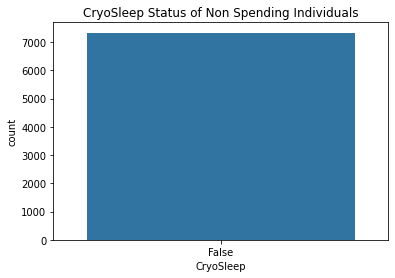

In [667]:
df_no_spending = df_all[df_all['TotalSpending'] == 0]
df_spending = df_all[df_all['TotalSpending'] > 0]
sns.countplot(data=df_spending, x=df_spending['CryoSleep'])
plt.title('CryoSleep Status of Non Spending Individuals')
plt.show()

In [668]:
df_no_spending.CryoSleep.value_counts()

True     4581
False     743
Name: CryoSleep, dtype: int64

Looks like those in cryosleep do indeed spend no money. Therefore it is safe to say if Total Spending > 0 cryosleep is False. If total spending is 0 then there is an 86% chance that the individual is in cryosleep. That is good enough for this dataset. Lets impute. 

In [669]:
df_all.loc[(df_all['CryoSleep'].isna()) & (df_all['TotalSpending'] > 0), 'CryoSleep'] = False
df_all.loc[(df_all['CryoSleep'].isna()) & (df_all['TotalSpending'] == 0), 'CryoSleep'] = True

In [670]:
df_all.CryoSleep.isna().sum()

0

**Destination**

In order to impute destination lets take a look at home planet and cabin features

In [671]:
df_dhp

HomePlanet,Earth,Europa,Mars
Destination,,,
55 Cancri e,1000,1339,300
PSO J318.5-22,1085,29,70
TRAPPIST-1e,4777,1769,2314


In [672]:
df_dcd = df_all.groupby(['CabinDeck', 'Destination']).size().unstack()
df_dcd

Destination,55 Cancri e,PSO J318.5-22,TRAPPIST-1e
CabinDeck,,,
A,157.0,2.0,190.0
B,507.0,5.0,606.0
C,465.0,20.0,596.0
D,175.0,17.0,513.0
E,166.0,58.0,1064.0
F,572.0,362.0,3209.0
G,533.0,693.0,2480.0
T,2.0,NaN,9.0


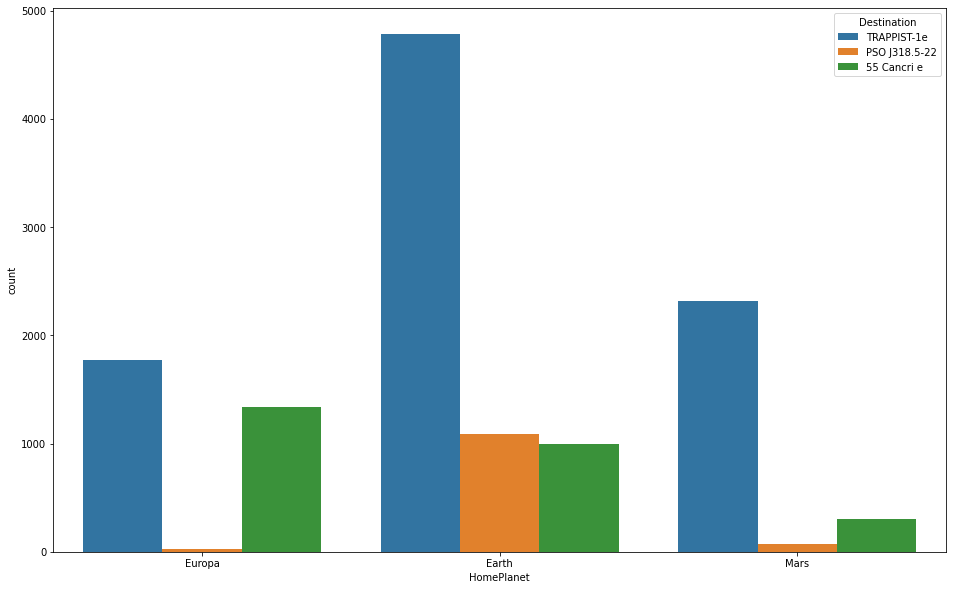

In [673]:
plt.figure(figsize=(16,10))
sns.countplot(data=df_all, x='HomePlanet', hue='Destination')
plt.show()

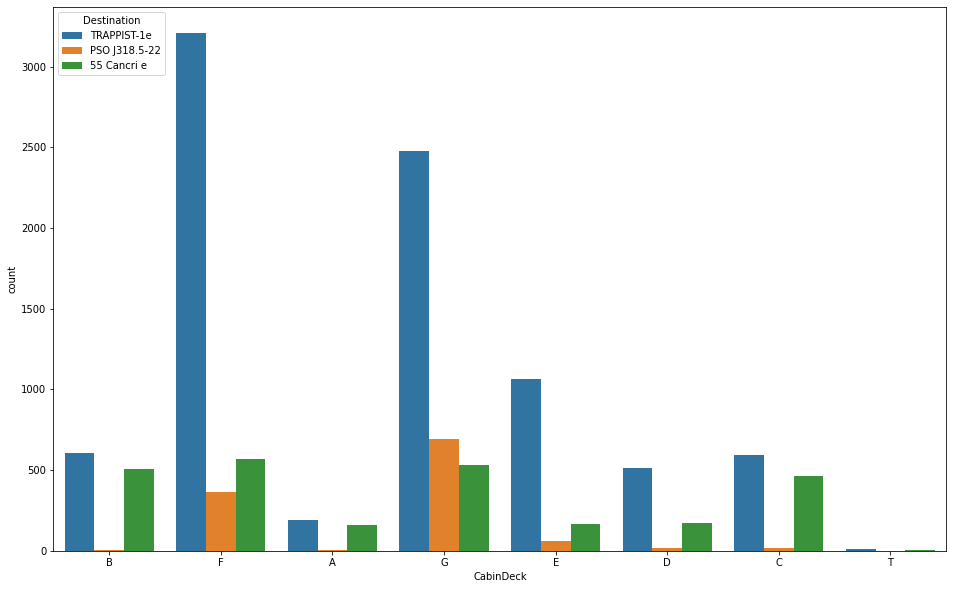

In [674]:
plt.figure(figsize=(16,10))
sns.countplot(data=df_all, x='CabinDeck', hue='Destination')
plt.show()

After investigation it is extremely hard to accurately discern whether a passenger is heading to TRAPPIST or Cancri. We can confidently eliminate PSO as a likely case in several instances, however, after that point it seems our best bet is to impute with TRAPPIST which is a more popular destination option than Cancri.  

In [675]:
df_all.Destination.fillna(df_all['Destination'].mode()[0], inplace=True)

In [676]:
df_all.Destination.isna().sum()

0

**VIP**

Since only around 2% of individuals are VIP we will impute with the mode. 

In [677]:
df_all.VIP.fillna(df_all['VIP'].mode()[0], inplace=True)

In [678]:
df_all.VIP.isna().sum()

0

**Cabinside**

First lets look at groups. Members of the same group are most likely going to be on the same cabinside 

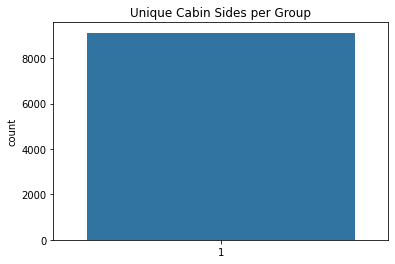

In [679]:
df_gcs = df_all.groupby(['GroupId', 'CabinSide']).size().unstack()
sns.countplot(x=(df_gcs>0).sum(axis=1))
plt.title('Unique Cabin Sides per Group')
plt.show()

Great, no unique cabin sides, lets impute. 

In [680]:
gcs_impute = df_all[df_all['CabinSide'].isna()][(df_all[df_all['CabinSide'].isna()]['GroupId']).isin(df_gcs.index)].index
df_all.loc[gcs_impute,'CabinSide']=df_all.iloc[gcs_impute,:]['GroupId'].map(lambda x: df_gcs.idxmax(axis=1)[x])

In [681]:
df_all.CabinSide.isna().sum()

162

Lets do the same thing with family.

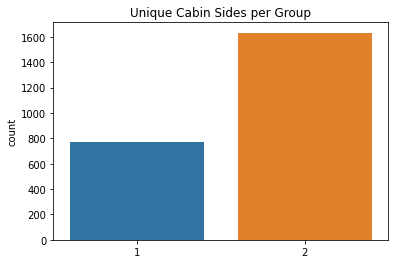

In [682]:
df_ncs = df_all.groupby(['Name', 'CabinSide']).size().unstack()
sns.countplot(x=(df_ncs>0).sum(axis=1))
plt.title('Unique Cabin Sides per Group')
plt.show()

Unfortunately families seem to be split up to different sides of the ship around 30% of the time. Lets see if there are any other features that can help us narrow it down. 

In [683]:
df_all.groupby(['CabinDeck', 'CabinSide']).size().unstack()
df_all.groupby(['CabinDeck', 'CabinSide']).size().unstack()

CabinSide,P,S
CabinDeck,,
A,166,188
B,512,629
C,533,569
D,370,350
E,641,682
F,2178,2061
G,1885,1896
T,5,6


Also pretty evenly split. Since we don't know how to impute the remaining values for certain lets impute with family then impute the rest with an outlier. 

In [684]:
ncs_impute = df_all[df_all['CabinSide'].isna()][(df_all[df_all['CabinSide'].isna()]['Name']).isin(df_ncs.index)].index
df_all.loc[ncs_impute,'CabinSide']=df_all.iloc[ncs_impute,:]['Name'].map(lambda x: df_ncs.idxmax(axis=1)[x])
df_all.CabinSide.isna().sum()

5

In [685]:
df_all.CabinSide.fillna('X', inplace=True)
df_all.CabinSide.isna().sum()

0

**CabinDeck**

To impute cabin deck lets look at groups and families once more

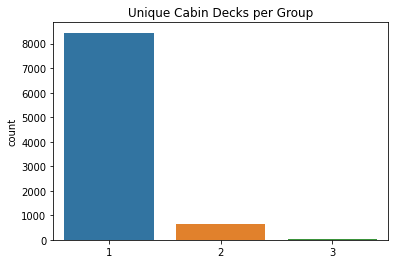

In [686]:
df_gcd = df_all.groupby(['GroupId', 'CabinDeck']).size().unstack()
sns.countplot(x=(df_gcd>0).sum(axis=1))
plt.title('Unique Cabin Decks per Group')
plt.show()

Looks like a vast majority of groups belong to the same cabin deck. Let's impute

In [687]:
gcd_impute = df_all[df_all['CabinDeck'].isna()][(df_all[df_all['CabinDeck'].isna()]['GroupId']).isin(df_gcd.index)].index
df_all.loc[gcd_impute,'CabinDeck']=df_all.iloc[gcd_impute,:]['GroupId'].map(lambda x: df_gcd.idxmax(axis=1)[x])
df_all.CabinDeck.isna().sum()

162

Now lets look at families. 

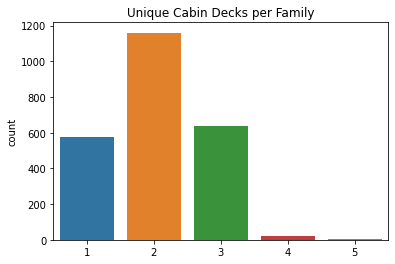

In [688]:
df_ncd = df_all.groupby(['Name', 'CabinDeck']).size().unstack()
sns.countplot(x=(df_ncd>0).sum(axis=1))
plt.title('Unique Cabin Decks per Family')
plt.show()

Unfortunately families are often split up, we are unable to use this data to impute. Let's try some other features. 

In [689]:
df_all.groupby(['HomePlanet', 'Destination', 'CabinDeck']).size().unstack().fillna(0)

CabinDeck                     A      B      C      D      E       F       G  \
HomePlanet Destination                                                        
Earth      55 Cancri e      0.0    0.0    0.0    0.0   67.0   379.0   541.0   
           PSO J318.5-22    0.0    0.0    0.0    0.0   43.0   329.0   696.0   
           TRAPPIST-1e      0.0    0.0    0.0    0.0  491.0  1788.0  2584.0   
Europa     55 Cancri e    163.0  518.0  472.0  105.0   69.0     0.0     0.0   
           PSO J318.5-22    2.0    5.0   21.0    0.0    0.0     0.0     0.0   
           TRAPPIST-1e    196.0  638.0  629.0  204.0  135.0     0.0     0.0   
Mars       55 Cancri e      0.0    0.0    0.0   72.0   31.0   196.0     0.0   
           PSO J318.5-22    0.0    0.0    0.0   17.0   16.0    35.0     0.0   
           TRAPPIST-1e      0.0    0.0    0.0  332.0  482.0  1541.0     0.0   

CabinDeck                   T  
HomePlanet Destination         
Earth      55 Cancri e    0.0  
           PSO J318.5-22  0.0  
           TRAPPIST-1e    0.0  
Europa     55 Cancri e    2.0  
           PSO J318.5-22  0.0  
           TRAPPIST-1e    9.0  
Mars       55 Cancri e    0.0  
           PSO J318.5-22  0.0  
           TRAPPIST-1e    0.0

Unfortunately, there doesn't seem to be a great way of imputing with a strong level of confidence so lets use the mode to impute. 

In [690]:
df_all['CabinDeck'].fillna(df_all.groupby(['HomePlanet', 'Destination'])['CabinDeck'].transform(lambda x: x.mode()[0]), inplace=True)
df_all.CabinDeck.isna().sum()

0

**Age**

There may be several features that are important to age lets look at a couple below. 

In [691]:
df_all[['Age', 'Destination']].groupby(['Destination']).mean()

,Age
Destination,
55 Cancri e,29.385328
PSO J318.5-22,27.350000
TRAPPIST-1e,28.778771


In [692]:
df_all[['Age', 'HomePlanet']].groupby(['HomePlanet']).mean()

,Age
HomePlanet,
Earth,25.940195
Europa,34.368606
Mars,29.518077


In [693]:
df_all[['Age', 'CryoSleep']].groupby(['CryoSleep']).mean()

,Age
CryoSleep,
False,29.523645
True,27.448815


In [694]:
df_all[['Age', 'GroupSize']].groupby(['GroupSize']).mean()

,Age
GroupSize,
1,30.446095
2,30.087248
3,24.419552
4,26.417219
5,23.284946
6,19.792683
7,21.235294
8,25.089041


In [695]:
df_all[['Age', 'CabinDeck']].groupby(['CabinDeck']).mean()

,Age
CabinDeck,
A,35.484330
B,33.591924
C,34.704277
D,33.418182
E,30.223412
F,28.394263
G,24.029726
T,35.545455


In [696]:
df_no_spending.Age.mean()

25.116676045770024

In [697]:
df_spending.Age.mean()

31.416338716243725

In [698]:
df_ats = df_all[['Age', 'TotalSpending']].groupby(['Age']).mean()

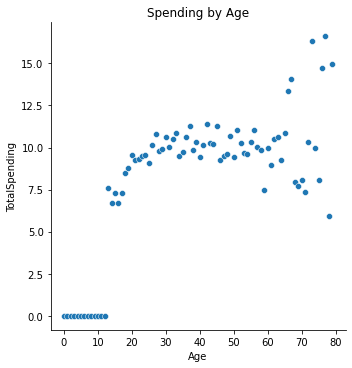

In [699]:
sns.relplot(
    data=df_ats,
    x="Age", y="TotalSpending"
)
plt.title('Spending by Age')
plt.show()

It seems like many factors affect age. In this case we can use MICE since there are many correlated factors affecting age. First One Hot Encoding is needed.  

**One Hot Encoding**

Lets get rid of high cardinality features and features that won't contribute to our final model. 

In [700]:
df_all.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP',
       'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name',
       'Transported', 'TotalSpending', 'GroupId', 'GroupSize', 'CabinDeck',
       'CabinNumber', 'CabinSide', 'CabinArea1', 'CabinArea2', 'CabinArea3',
       'CabinArea4', 'CabinArea5', 'CabinArea6'],
      dtype='object')

In [701]:
df_all.drop(columns=['Name', 'PassengerId', 'GroupId', 'CabinNumber'], axis=1, inplace=True)

In [702]:
df_all.shape

(12970, 21)

In [703]:
#Converting to bool so cryosleep and Transported are not one hot encoded. 
df_all['Transported'] = df_all['Transported'].astype('bool')
df_all['CryoSleep'] = df_all['CryoSleep'].astype('bool')

In [704]:
df_all_ohe = pd.get_dummies(df_all)
df_all_ohe.shape

(12970, 34)

In [705]:
df_mice_cols = ['Age', 'TotalSpending', 'GroupSize', 'HomePlanet_Earth', 'HomePlanet_Mars', 'HomePlanet_Europa', 'CabinDeck_A', 'CabinDeck_B', 'CabinDeck_C', 'CabinDeck_D', 'CabinDeck_E', 'CabinDeck_G' , 'CabinDeck_F', 'CabinDeck_T']

In [706]:
# Imputing with MICE
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import ensemble

df_mice = df_all_ohe.filter(df_mice_cols, axis=1).copy()

# Define MICE Imputer and fill missing values
mice_imputer = IterativeImputer(estimator=ensemble.RandomForestRegressor())

df_mice_imputed = pd.DataFrame(mice_imputer.fit_transform(df_mice), columns=df_mice.columns)

/opt/conda/lib/python3.7/site-packages/sklearn/impute/_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,


In [707]:
df_all_ohe['Age'] = df_mice_imputed['Age']

In [708]:
df_all_ohe.isna().sum()

CryoSleep                    0
Age                          0
VIP                          0
RoomService                  0
FoodCourt                    0
ShoppingMall                 0
Spa                          0
VRDeck                       0
Transported                  0
TotalSpending                0
GroupSize                    0
CabinArea1                   0
CabinArea2                   0
CabinArea3                   0
CabinArea4                   0
CabinArea5                   0
CabinArea6                   0
HomePlanet_Earth             0
HomePlanet_Europa            0
HomePlanet_Mars              0
Destination_55 Cancri e      0
Destination_PSO J318.5-22    0
Destination_TRAPPIST-1e      0
CabinDeck_A                  0
CabinDeck_B                  0
CabinDeck_C                  0
CabinDeck_D                  0
CabinDeck_E                  0
CabinDeck_F                  0
CabinDeck_G                  0
CabinDeck_T                  0
CabinSide_P                  0
CabinSid

In [709]:
#Converting features back to int for modeling
df_all_ohe['Transported'] = df_all_ohe['Transported'].replace({True: 1, False: 0})
df_all_ohe['CryoSleep'] = df_all_ohe['CryoSleep'].replace({True: 1, False: 0})
df_all_ohe['VIP'] = df_all_ohe['VIP'].replace({True: 1, False: 0})

In [710]:
#Splitting back into training and testing datasets

train = df_all_ohe[:len(df_train)]
test = df_all_ohe[len(df_train):]

In [711]:
#dropping transported column for test dataset 

test.drop(columns='Transported', axis=1, inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


# Modeling

Lets use several popular models and evaluate their base accuracy using cross validation

In [712]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [713]:
X = train.drop(columns='Transported', axis=1)
y = train.Transported
# random state
rs = 5

classifiers = ['lr', 'dtc', 'rfc', 'knn', 'svc', 'xgb', 'cbc', 'vc']
cv_scores = []

In [714]:
lr = LogisticRegression(random_state=rs, max_iter=2500)
cv = cross_val_score(lr, X, y, cv=5)
cv_scores.append(cv.mean())
cv.mean()

0.7733827160167046

In [715]:
dtc = DecisionTreeClassifier(random_state=rs)
cv = cross_val_score(dtc, X, y, cv=5)
cv_scores.append(cv.mean())
cv.mean()

0.7349583871264453

In [716]:
rfc = RandomForestClassifier(random_state=rs)
cv = cross_val_score(rfc, X, y, cv=5)
cv_scores.append(cv.mean())
cv.mean()

0.7912148762135296

In [717]:
knn = KNeighborsClassifier()
cv = cross_val_score(knn, X, y, cv=5)
cv_scores.append(cv.mean())
cv.mean()

0.7481898052595602

In [ ]:
svc = SVC(random_state=rs, probability=True)
cv = cross_val_score(svc, X, y, cv=5)
cv_scores.append(cv.mean())
cv.mean()

In [ ]:
xgb = XGBClassifier(random_state=rs)
cv = cross_val_score(xgb, X, y, cv=5)
cv_scores.append(cv.mean())
cv.mean()

In [ ]:
cbc = CatBoostClassifier(random_state=rs, verbose=False)
cv = cross_val_score(cbc, X, y, cv=5)
cv_scores.append(cv.mean())
cv.mean()

In [721]:
vc = VotingClassifier(estimators = [('lr', lr), ('dtc', dtc), ('rfc', rfc),
                                   ('knn', knn), ('svc', svc), ('xgb', xgb),
                                   ('cbc', cbc)], voting = 'soft')
cv = cross_val_score(vc, X, y , cv=5)
cv_scores.append(cv.mean())
cv.mean()

0.7967363490121369

In [722]:
model_scores = pd.DataFrame({'Model': classifiers, 'Scores': cv_scores})
model_scores

,Model,Scores
0,lr,0.773383
1,dtc,0.734958
2,rfc,0.791215
3,knn,0.748190
4,svc,0.771428
5,xgb,0.783622
6,cbc,0.797427
7,vc,0.796736


# Model Tuning

In [723]:
#Now lets see if we can improve the performance of our three best models: 
#XGBoost, CatBoost, and RandomForest

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

**Random Forest**

In [724]:
'''params = {
    'n_estimators': [100, 250, 500, 750, 1000],
    'max_depth': [3, 5, 10, 20],
    'criterion': ['gini', 'entropy'],
    'min_samples_leaf': [2, 4, 6],
    'min_samples_split': [2, 5, 7, 10]
}

rfc_rs = RandomizedSearchCV(rfc, n_iter = 50, param_distributions = params, cv =5, 
                            verbose= False, n_jobs = -1)
rfc_rs.fit(X, y)
rfc_rs.best_estimator_'''

"params = {\n    'n_estimators': [100, 250, 500, 750, 1000],\n    'max_depth': [3, 5, 10, 20],\n    'criterion': ['gini', 'entropy'],\n    'min_samples_leaf': [2, 4, 6],\n    'min_samples_split': [2, 5, 7, 10]\n}\n\nrfc_rs = RandomizedSearchCV(rfc, n_iter = 50, param_distributions = params, cv =5, \n                            verbose= False, n_jobs = -1)\nrfc_rs.fit(X, y)\nrfc_rs.best_estimator_"

In [725]:
'''params = {
    'n_estimators': [900, 1000],
    'max_depth': [21],
    'min_samples_leaf': [5],
    'min_samples_split': [11]
}

rfc_gs = GridSearchCV(rfc, param_grid = params, cv =5, 
                            verbose= True, n_jobs = -1)
rfc_gs.fit(X, y)
rfc_gs.best_estimator_'''

"params = {\n    'n_estimators': [900, 1000],\n    'max_depth': [21],\n    'min_samples_leaf': [5],\n    'min_samples_split': [11]\n}\n\nrfc_gs = GridSearchCV(rfc, param_grid = params, cv =5, \n                            verbose= True, n_jobs = -1)\nrfc_gs.fit(X, y)\nrfc_gs.best_estimator_"

In [726]:
best_rfc = RandomForestClassifier(criterion='entropy', max_depth=21, min_samples_leaf=5, min_samples_split=11,
                       n_estimators=900, random_state=5)

**XGBoost**

In [727]:
'''params = {
    'n_estimators': [500, 750, 1000],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.08],
    'min_child_weight': [0.01, 0.1, 1],
    'reg_alpha': [0, 0.5],
    'reg_lambda': [1, 1.5]
}

xgb_rs = RandomizedSearchCV(xgb, n_iter = 30, param_distributions = params, cv =5, 
                            verbose= True, n_jobs = -1)
xgb_rs.fit(X, y)
xgb_rs.best_estimator_'''

"params = {\n    'n_estimators': [500, 750, 1000],\n    'max_depth': [3, 5, 7],\n    'learning_rate': [0.05, 0.08],\n    'min_child_weight': [0.01, 0.1, 1],\n    'reg_alpha': [0, 0.5],\n    'reg_lambda': [1, 1.5]\n}\n\nxgb_rs = RandomizedSearchCV(xgb, n_iter = 30, param_distributions = params, cv =5, \n                            verbose= True, n_jobs = -1)\nxgb_rs.fit(X, y)\nxgb_rs.best_estimator_"

In [728]:
'''params = {
    'n_estimators': [1200, 1300],
    'max_depth': [4, 5],
    'learning_rate': [0.01],
    'min_child_weight': [0.1, 1],
    'reg_alpha': [0.5],
    'reg_lambda': [1.5]
}

xgb_gs = GridSearchCV(xgb, param_grid = params, cv =5, 
                            verbose= True, n_jobs = -1)
xgb_gs.fit(X, y)
xgb_gs.best_estimator_'''

"params = {\n    'n_estimators': [1200, 1300],\n    'max_depth': [4, 5],\n    'learning_rate': [0.01],\n    'min_child_weight': [0.1, 1],\n    'reg_alpha': [0.5],\n    'reg_lambda': [1.5]\n}\n\nxgb_gs = GridSearchCV(xgb, param_grid = params, cv =5, \n                            verbose= True, n_jobs = -1)\nxgb_gs.fit(X, y)\nxgb_gs.best_estimator_"

In [729]:
best_xgb = XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
              monotone_constraints='()', n_estimators=1300,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=5,
              reg_alpha=0.5, reg_lambda=1.5)

**CatBoost**

In [730]:
'''params = {
    'iterations': [750, 1000, 1200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.03, 0.05],
}

cbc_rs = RandomizedSearchCV(cbc, n_iter = 20, param_distributions = params, cv =5, 
                            verbose= True, n_jobs = -1)
cbc_rs.fit(X, y)
cbc_rs.best_params_'''

"params = {\n    'iterations': [750, 1000, 1200],\n    'max_depth': [3, 5, 7],\n    'learning_rate': [0.01, 0.03, 0.05],\n}\n\ncbc_rs = RandomizedSearchCV(cbc, n_iter = 20, param_distributions = params, cv =5, \n                            verbose= True, n_jobs = -1)\ncbc_rs.fit(X, y)\ncbc_rs.best_params_"

In [731]:
'''params = {
    'iterations': [400, 750, 900],
    'max_depth': [3, 4],
    'learning_rate': [0.01, 0.03]
}

cbc_gs = GridSearchCV(cbc, param_grid = params, cv =5, 
                            verbose= True, n_jobs = -1)
cbc_gs.fit(X, y)
cbc_gs.best_params_'''

"params = {\n    'iterations': [400, 750, 900],\n    'max_depth': [3, 4],\n    'learning_rate': [0.01, 0.03]\n}\n\ncbc_gs = GridSearchCV(cbc, param_grid = params, cv =5, \n                            verbose= True, n_jobs = -1)\ncbc_gs.fit(X, y)\ncbc_gs.best_params_"

In [732]:
best_cbc = CatBoostClassifier(random_state=rs, iterations = 400, 
                              learning_rate = 0.03, max_depth = 3, verbose=False)

**Voting Classifier**

In [733]:
# lets see if a voting classifier can do better than any one of our models.
vc_soft = VotingClassifier(estimators = [('best_xgb', best_xgb), ('best_rfc', best_rfc), 
                                         ('best_cbc', best_cbc)], voting = 'soft')

cross_val_score(vc_soft, X, y, cv=5).mean()

0.8016837051041199

In [734]:
vc_hard = VotingClassifier(estimators = [('best_xgb', best_xgb), ('best_rfc', best_rfc), 
                                         ('best_cbc', best_cbc)], voting = 'hard')
cross_val_score(vc_hard, X, y, cv=5).mean()

0.802144599855346

Looks like our hard voting classifier performed the best of all of our models. Lets upload to Kaggle and see our results. I will make a submission for each model in case they perform better on the testing dataset. 

# Predictions

In [735]:
vc_soft.fit(X, y)
vc_hard.fit(X, y)
best_xgb.fit(X, y)
best_cbc.fit(X, y)
best_rfc.fit(X, y)

RandomForestClassifier(criterion='entropy', max_depth=21, min_samples_leaf=5,
                       min_samples_split=11, n_estimators=900, random_state=5)

In [736]:
vcs_pred = vc_soft.predict(test)
vch_pred = vc_hard.predict(test)
xgb_pred = best_xgb.predict(test)
cbc_pred = best_cbc.predict(test)
rfc_pred = best_rfc.predict(test)

In [749]:
#convert predictions to true and false as per competition guidelines
vcs_pred = np.array(vcs_pred, dtype=bool)
vch_pred = np.array(vch_pred, dtype=bool)
xgb_pred = np.array(xgb_pred, dtype=bool)
cbc_pred = np.array(cbc_pred, dtype=bool)
rfc_pred = np.array(rfc_pred, dtype=bool)

In [751]:
vcs_output = pd.DataFrame({'PassengerId': df_test.PassengerId, 'Transported': vcs_pred})
vcs_output.to_csv('vcs.csv', index=False)

vch_output = pd.DataFrame({'PassengerId': df_test.PassengerId, 'Transported': vch_pred})
vch_output.to_csv('vch.csv', index=False)

xgb_output = pd.DataFrame({'PassengerId': df_test.PassengerId, 'Transported': xgb_pred})
xgb_output.to_csv('xgb.csv', index=False)

cbc_output = pd.DataFrame({'PassengerId': df_test.PassengerId, 'Transported': cbc_pred})
cbc_output.to_csv('cbc.csv', index=False)

rfc_output = pd.DataFrame({'PassengerId': df_test.PassengerId, 'Transported': rfc_pred})
rfc_output.to_csv('rfc.csv', index=False)